## Import Surfperch

In [1]:
import tensorflow_hub as hub
import numpy as np

# Load the model.
model = hub.load('https://www.kaggle.com/models/google/surfperch/TensorFlow2/1/1')

# Input: 5 seconds of silence as mono 32 kHz waveform samples.
waveform = np.zeros(5 * 32000, dtype=np.float32)

# Run the model, check the output.
outputs = model.infer_tf(waveform[np.newaxis, :])


/opt/anaconda3/envs/fish_embed/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
2025-12-06 14:49:53.218338: I external/local_xla/xla/service/service.cc:163] XLA service 0x31dc2f1a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-12-06 14:49:53.218382: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-12-06 14:49:53.466681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-06 14:49:53.493223: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator jax2tf_infer_fn_

#### test

In [4]:
wav = np.zeros(32000*5, dtype=np.float32)  # 5 seconds of silence

outputs = model.infer_tf(wav[np.newaxis, :])  # batch size 1
emb_tf = outputs["embedding"]                 # tf.Tensor, shape (1, 1280)
emb = emb_tf.numpy().squeeze(0)              # NumPy array, shape (1280,)

print(emb.shape)  # (1280,)


(1280,)


## Process Audio Files

In [6]:
from pathlib import Path
import numpy as np
import librosa
import umap
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_hub as hub

/opt/anaconda3/envs/fish_embed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
AUDIO_ROOT = Path("/Users/wendycao/fish/processed/audio_clips_5s")
TARGET_SR = 32000
TARGET_SEC = 5.0
TARGET_SAMPLES = int(TARGET_SR * TARGET_SEC)

In [8]:
def load_wave_5s_mono_32k(path):
    """Load audio file, convert to mono 32 kHz, center-crop/pad to 5 seconds."""
    wav, sr = librosa.load(path, sr=None, mono=True)

    # Resample if needed
    if sr != TARGET_SR:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=TARGET_SR)

    # Ensure exactly 5 seconds: center crop or pad with zeros
    if len(wav) > TARGET_SAMPLES:
        start = (len(wav) - TARGET_SAMPLES) // 2
        wav = wav[start:start + TARGET_SAMPLES]
    elif len(wav) < TARGET_SAMPLES:
        pad = TARGET_SAMPLES - len(wav)
        left = pad // 2
        right = pad - left
        wav = np.pad(wav, (left, right), mode="constant")

    return wav.astype(np.float32)


def surfperch_embed_file(path):
    """Return SurfPerch embedding (1280,) for a single audio file."""
    wav = load_wave_5s_mono_32k(path)
    outputs = model.infer_tf(wav[np.newaxis, :])   # shape (1, 160000)
    emb_tf = outputs["embedding"]                  # tf.Tensor, (1, 1280)
    emb = emb_tf.numpy().squeeze(0)                # numpy array, (1280,)
    return emb


### Embed

In [9]:
if not AUDIO_ROOT.exists():
    raise SystemExit("AUDIO_ROOT does not exist: {}".format(AUDIO_ROOT))

embeddings = []
species_labels = []
clip_paths = []

species_dirs = [d for d in AUDIO_ROOT.iterdir() if d.is_dir()]
print("Found {} species folders under {}".format(len(species_dirs), AUDIO_ROOT))

for species_dir in sorted(species_dirs):
    species = species_dir.name
    wav_files = sorted(species_dir.glob("*.wav"))

    print("\nSpecies: {}  ({} clips)".format(species, len(wav_files)))
    for i, wav_path in enumerate(wav_files):
        rel = wav_path.relative_to(AUDIO_ROOT)
        print("  [{}/{}] {}".format(i + 1, len(wav_files), rel))

        try:
            emb = surfperch_embed_file(str(wav_path))
        except Exception as e:
            print("    -> FAILED to embed (skipping):", e)
            continue

        embeddings.append(emb)
        species_labels.append(species)
        clip_paths.append(str(rel))

embeddings = np.stack(embeddings)
print("\nCollected embeddings:", embeddings.shape)

Found 46 species folders under /Users/wendycao/fish/processed/audio_clips_5s

Species: Abudefduf saxatilis  (8 clips)
  [1/8] Abudefduf saxatilis/FEC-00136 Abudefduf saxatilis_det000.wav
  [2/8] Abudefduf saxatilis/FEC-00137 Abudefduf saxatilis_det000.wav
  [3/8] Abudefduf saxatilis/FEC-00138 Abudefduf saxatilis_det000.wav
  [4/8] Abudefduf saxatilis/FEC-00138 Abudefduf saxatilis_det001.wav
  [5/8] Abudefduf saxatilis/FEC-00138 Abudefduf saxatilis_det002.wav
  [6/8] Abudefduf saxatilis/FEC-00138 Abudefduf saxatilis_det003.wav
  [7/8] Abudefduf saxatilis/FEC-00139 Abudefduf saxatilis_det000.wav
  [8/8] Abudefduf saxatilis/FEC-00140 Abudefduf saxatilis_det000.wav

Species: Acanthurus coeruleus  (5 clips)
  [1/5] Acanthurus coeruleus/FEC-00006 Acanthurus coeruleus_det000.wav
  [2/5] Acanthurus coeruleus/FEC-00007 Acanthurus coeruleus_det000.wav
  [3/5] Acanthurus coeruleus/FEC-00008 Acanthurus coeruleus_det000.wav
  [4/5] Acanthurus coeruleus/FEC-00009 Acanthurus coeruleus_det000.wav
  [5

## UMAP

In [10]:
print("Running UMAP...")
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)
emb_2d = reducer.fit_transform(embeddings)
print("UMAP done. emb_2d shape:", emb_2d.shape)

Running UMAP...


/opt/anaconda3/envs/fish_embed/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done. emb_2d shape: (219, 2)


## Plot

Saved UMAP plot to: /Users/wendycao/fish/processed/surfperch_umap.png


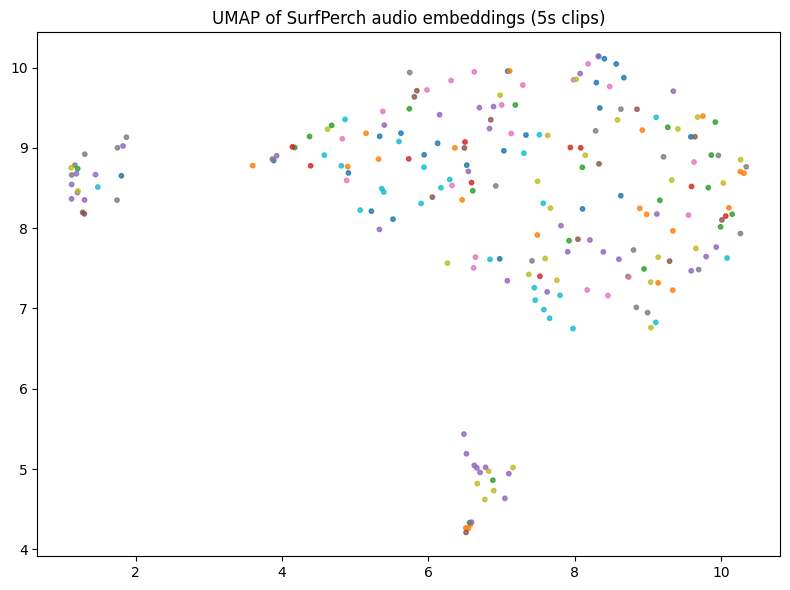

In [11]:
if emb_2d.shape[0] == 0:
    print("No points to plot.")
else:
    unique_species = sorted(set(species_labels))
    species_to_idx = {s: i for i, s in enumerate(unique_species)}
    color_indices = np.array([species_to_idx[s] for s in species_labels])

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=color_indices,
        s=10,
        alpha=0.8,
        cmap="tab10",
    )
    plt.title("UMAP of SurfPerch audio embeddings (5s clips)")
    plt.tight_layout()

    # Optional: save figure as PNG
    out_png = AUDIO_ROOT.parent / "surfperch_umap.png"
    plt.savefig(out_png, dpi=300)
    print("Saved UMAP plot to:", out_png)

    plt.show()

## Save Results

In [12]:
out_dir = AUDIO_ROOT.parent / "surfperch_embeddings"
out_dir.mkdir(exist_ok=True)

np.save(out_dir / "embeddings.npy", embeddings)
meta_df = pd.DataFrame(
    {
        "clip_path": clip_paths,
        "species": species_labels,
    }
)
meta_df.to_csv(out_dir / "metadata.csv", index=False)

print("Saved embeddings to:", out_dir / "embeddings.npy")
print("Saved metadata to:", out_dir / "metadata.csv")

Saved embeddings to: /Users/wendycao/fish/processed/surfperch_embeddings/embeddings.npy
Saved metadata to: /Users/wendycao/fish/processed/surfperch_embeddings/metadata.csv
